In [2]:
import time
import datetime
import pandas as pd
import numpy as np
from scipy import stats
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
countries_list = {
    'usa': {'code': 'US', 'eu': 'US'},
    'uk': {'code': 'GB', 'eu': 'UK'},
    'canada': {'code': 'CA', 'eu': 'CA'},
    #'australia': {'code': 'AU', 'eu': 'AU'},
    #'nigeria': {'code': 'NG', 'eu': 'NG'},
    #'south africa': {'code': 'ZA', 'eu': 'ZA'},
    'ireland': {'code': 'IE', 'eu': 'IE'},
    #'new zealand': {'code': 'NZ', 'eu': 'NZ'},
    #'jamaica': {'code': 'JM', 'eu': 'JM'}
}

phrase_list = {
    'a': 'loss of smell',
    'b': 'lost sense of smell',
    'c': 'no sense of smell',
    'd': 'can\'t smell'
}

In [4]:
pytrend = TrendReq(timeout=(10,60))

def get_trend_data_stacked(countries, phrases):
    result = pd.DataFrame()
    counter = 0
    for c in countries:
        #Payload variables
        geo_id = countries[c]['code']
        eu_id = countries[c]['eu']
        
        for p in phrases:
            #Set phrase
            phrase = phrases[p]
            pytrend.build_payload([phrase], timeframe='2019-12-28 2020-03-27', geo=geo_id)
            trends_result = pytrend.interest_over_time()
            trends_result = trends_result.rename(columns={phrase: 'trend_index'})
            
            #Cleanup 
            if 'isPartial' in trends_result.columns:
                cleanup = trends_result.drop(columns=['isPartial'])
            cleanup['geo_id'] = geo_id
            cleanup['eu_id'] = eu_id
            cleanup['phrase'] = phrase
            cleanup['phrase_id'] = p
            
            #Set first df if empty
            if result.empty:
                result = cleanup
            else:
                result = result.append(cleanup)
            #WHY?! Only adding this sleep makes google trends work
            time.sleep(7)
            counter += 1
            print(counter, ' / ', (len(countries) * len(phrases)))
    result['year_week'] = result.index.year.astype(str) + "_" + result.index.week.astype(str)
    return result

In [6]:
#Uncomment line below to refresh phrase trend data...
#...However there is no need to do this as the data is limited at from 23rd March onwards
#phrase_results = get_trend_data_stacked(countries_list, phrase_list)

In [8]:
#phrase_results.to_csv('phrase_results.csv')

In [9]:
raw_corona = pd.read_excel('https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx',
                          index_col=None, usecols=['dateRep', 'cases', 'deaths', 'countriesAndTerritories', 'geoId'],
                          dtype={'cases': int, 'deaths': int, 'countriesAndTerritories': str, 'geoId': str},
                          parse_dates=['dateRep'])


In [10]:
#Offline file from previous set
df_csv = pd.read_csv('phrase_results.csv', parse_dates=['date']).reset_index()
df_csv = df_csv.loc[df_csv['geo_id'].isin(['US', 'GB', 'CA', 'IE'])]

#Add baseline data
df_csv['pre_corona_trend_baseline'] = df_csv.apply(
    lambda x: df_csv['trend_index'].loc[(df_csv['geo_id'] == x['geo_id']) & (df_csv['phrase_id'] == x['phrase_id']) & (df_csv['date'] < '2020-01-31')].mean(), axis=1)
df_csv['baseline_diff'] = df_csv.apply(lambda x: 0 if(x['pre_corona_trend_baseline'] == 0)\
                                        else (x['trend_index'] / x['pre_corona_trend_baseline']), axis=1)

phrase_trends_merge = df_csv.merge(raw_corona, left_on=['eu_id', 'date'], right_on=['geoId', 'dateRep'])

phrase_trends_merge['cases_index'] = phrase_trends_merge.apply(
    lambda x: 100 * (x['cases'] / phrase_trends_merge['cases'].loc[phrase_trends_merge['geo_id'] == x['geo_id']].max()), axis=1)

phrase_trends_merge['deaths_index'] = phrase_trends_merge.apply(
    lambda x: 100 * (x['deaths'] / phrase_trends_merge['deaths'].loc[phrase_trends_merge['geo_id'] == x['geo_id']].max()), axis=1)


In [11]:
def plot_trends():
    df = phrase_trends_merge.loc[phrase_trends_merge['date'] > '2020-02-15']
    fig, ax = plt.subplots(3, 4, figsize=(25,11))
    myFmt = mdates.DateFormatter('%m / %d')
    
    for p in phrase_list:
        ax[0,0].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'US')],
         df['trend_index'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'US')], label=df['geo_id'], lw=2)
    ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[0,0].tick_params(axis='y', labelsize=20)
    ax[0,0].set_ylim(0, 100)
    ax[0,0].set_ylabel('Search interest \n(raw)', size=22)
    ax[0,0].set_title('USA', size=24)
    ax[0,0].legend(phrase_list.values(), loc='upper left', fontsize=16)
    
    for p in phrase_list:
        ax[1,0].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'US')],
         df['baseline_diff'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'US')], label=df['geo_id'], lw=2)
    ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[1,0].tick_params(axis='y', labelsize=20)
    ax[1,0].set_ylim(0, 100)
    ax[1,0].set_ylabel('Search interest \n(baseline normalised)', size=22)
    ax[1,0].legend(phrase_list.values(), loc='upper left', fontsize=16)
    
    ax[2,0].plot(df['date'].loc[df['geo_id'] == 'US'], df['deaths'].loc[df['geo_id'] == 'US'],\
                 label=df['geo_id'], color='purple', lw=2)
    ax[2,0].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[2,0].tick_params(axis='x', labelrotation=50, labelsize=20)
    ax[2,0].tick_params(axis='y', labelsize=20)
    ax[2,0].set_ylim(0, 140)
    ax[2,0].set_ylabel('deaths', size=22)
    ax[2,0].xaxis.set_major_formatter(myFmt)
    
    for p in phrase_list:
        ax[0,1].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'GB')],
         df['trend_index'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'GB')], label=df['geo_id'], lw=2)
    ax[0,1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[0,1].set_ylim(0, 100)
    ax[0,1].set_title('UK', size=24)
    
    for p in phrase_list:
        ax[1,1].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'GB')],
         df['baseline_diff'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'GB')], label=df['geo_id'], lw=2)
    ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[1,1].set_ylim(0, 100)
    
    ax[2,1].plot(df['date'].loc[df['geo_id'] == 'GB'], df['deaths'].loc[df['geo_id'] == 'GB'],\
                 label=df['geo_id'], color='purple', lw=2)
    ax[2,1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[2,1].tick_params(labelrotation=50, labelsize=20)
    ax[2,1].set_ylim(0, 140)
    ax[2,1].xaxis.set_major_formatter(myFmt)
    
    for p in phrase_list:
        ax[0,2].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'CA')],
         df['trend_index'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'CA')], label=df['geo_id'], lw=2)
    ax[0,2].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[0,2].set_ylim(0, 100)
    ax[0,2].set_title('Canada', size=24)
    
    for p in phrase_list:
        ax[1,2].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'CA')],
         df['baseline_diff'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'CA')], label=df['geo_id'], lw=2)
    ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[1,2].set_ylim(0, 100)
    
    ax[2,2].plot(df['date'].loc[df['geo_id'] == 'CA'], df['deaths'].loc[df['geo_id'] == 'CA'],\
                 label=df['geo_id'], color='purple', lw=2)
    ax[2,2].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[2,2].tick_params(labelrotation=50, labelsize=20)
    ax[2,2].set_ylim(0, 140)
    ax[2,2].xaxis.set_major_formatter(myFmt)
    
    for p in phrase_list:
        ax[0,3].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'IE')],
         df['trend_index'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'IE')], label=df['geo_id'], lw=2)
    ax[0,3].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[0,3].set_ylim(0, 100)
    ax[0,3].set_title('Ireland', size=24)
    
    for p in phrase_list:
        ax[1,3].plot(df['date'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'IE')],
         df['baseline_diff'].loc[(df['phrase_id'] == p) & (df['geo_id'] == 'IE')], label=df['geo_id'], lw=2)
    ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[1,3].set_ylim(0, 100)
    
    ax[2,3].plot(df['date'].loc[df['geo_id'] == 'IE'], df['deaths'].loc[df['geo_id'] == 'IE'],\
                 label=df['geo_id'], color='purple', lw=2)
    ax[2,3].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[2,3].tick_params(labelrotation=50, labelsize=20)
    ax[2,3].set_ylim(0, 140)
    ax[2,3].xaxis.set_major_formatter(myFmt)
    
    
    for ax in fig.get_axes():
        ax.label_outer()
    
    fig.suptitle('Daily deaths and search interest for "anosmia" over time by country', fontsize=25, y=1)
    fig.tight_layout(rect=(0,0,1,0.94))
    
    fig.savefig('no_smell.png')

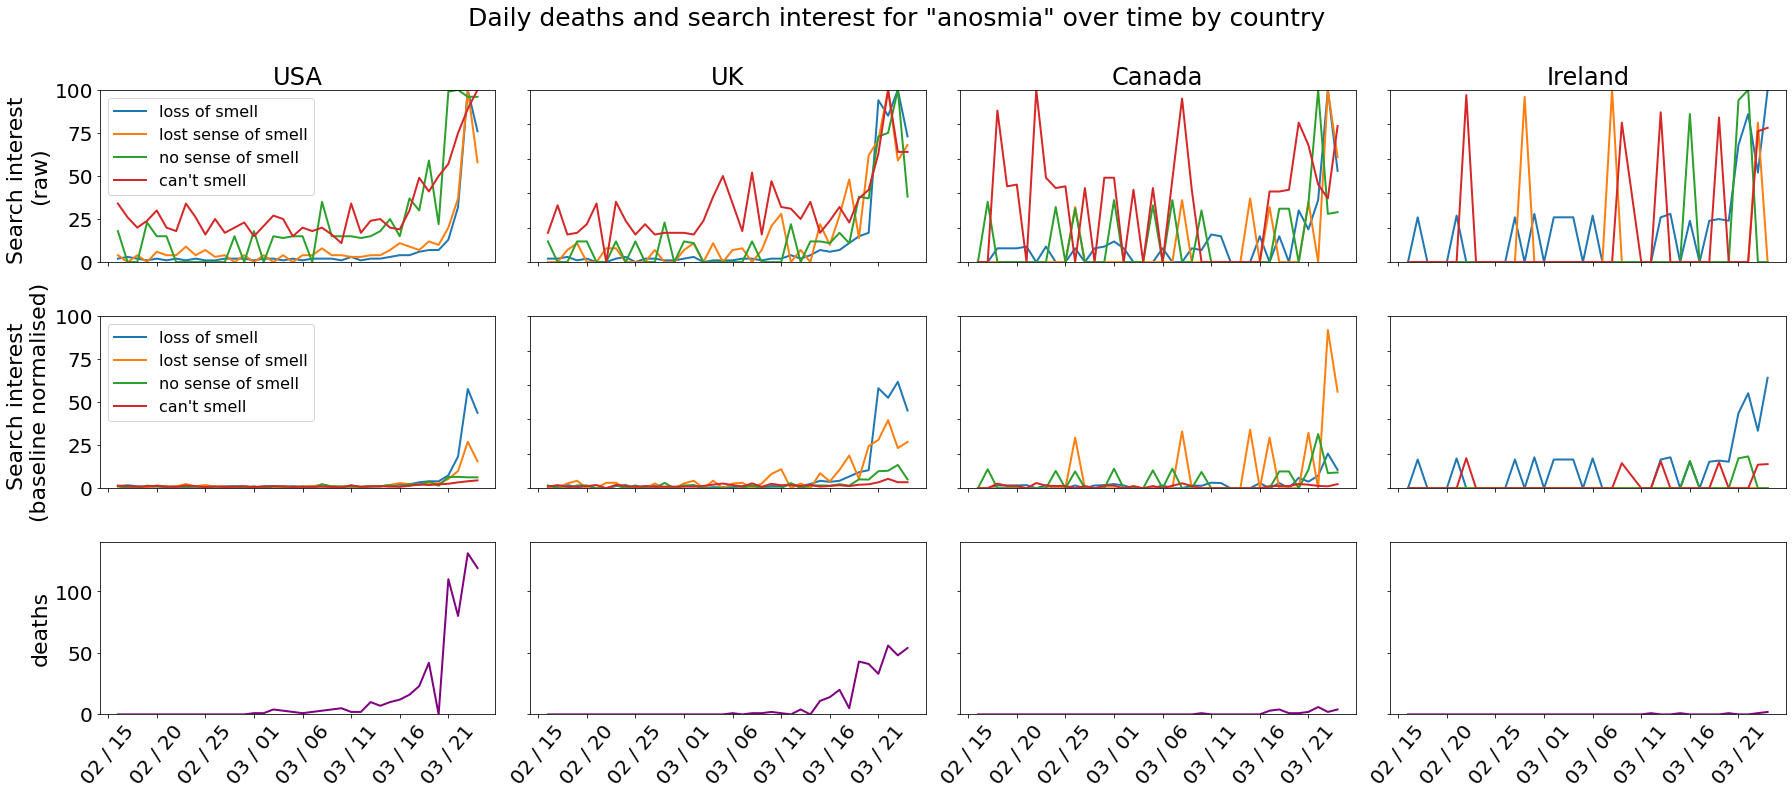

In [12]:
plot_trends()

In [13]:
def spearman():
    df = phrase_trends_merge
    for country in ['GB', 'US', 'CA', 'IE']:
        for p in phrase_list:
            res = stats.spearmanr(df['deaths'].loc[(df['phrase_id'] == p) & (df['geo_id'] == country)],\
                                 df['trend_index'].loc[(df['phrase_id'] == p) & (df['geo_id'] == country)])
            res_correlation = round(res.correlation, 3)
            if (res.pvalue < 0.001):
                p_res = '<0.001'
            else:
                p_res = round(res.pvalue, 3)
            print(country, '    ', phrase_list[p], '    ', res_correlation, '    ', p_res)

In [14]:
spearman()

GB      loss of smell      0.499      <0.001
GB      lost sense of smell      0.601      <0.001
GB      no sense of smell      0.31      0.004
GB      can't smell      0.461      <0.001
US      loss of smell      0.424      <0.001
US      lost sense of smell      0.295      0.006
US      no sense of smell      0.32      0.003
US      can't smell      0.169      0.121
CA      loss of smell      0.302      0.005
CA      lost sense of smell      0.424      <0.001
CA      no sense of smell      0.484      <0.001
CA      can't smell      0.078      0.478
IE      loss of smell      0.216      0.049
IE      lost sense of smell      0.168      0.129
IE      no sense of smell      -0.077      0.491
IE      can't smell      0.241      0.028
